<a href="https://colab.research.google.com/github/tina287/fianceHomework/blob/main/%E9%87%91%E8%9E%8D%E5%A4%A7%E6%95%B8%E6%93%9AHW_ANN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
import yfinance as yf
import datetime as dt

In [13]:
stock_id = '2330.tw'
# stock_id = '2357.tw'
# stock_id = '2317.tw'
# stock_id = 'AAPL'
# stock_id = 'NVDA'

'''今天往前算幾天'''
# 資料結束時間
end = dt.date.today()
# 抓取半年資料（現在-過去180天）
start = end - dt.timedelta(days=180)

'''抓取特定時間'''
# start = dt.datetime(2020, 1, 1)  # 指定的開始日期
# end = dt.datetime(2024, 10, 10)    # 指定的結束日期


# 參數1: 股票代號, 參數2: 開始時間, 參數3: 結束時間
stock_data = yf.download(stock_id, start=start, end=end).reset_index()

# 將日期欄位轉為datetime格式
stock_data["Date"] = pd.to_datetime(stock_data["Date"])
# 將日期欄位設為索引
stock_data.set_index("Date", inplace=True)

# 刪除 Ticker 欄位並取代
stock_data.columns = stock_data.columns.droplevel('Ticker')

stock_data

[*********************100%***********************]  1 of 1 completed


Price,Adj Close,Close,High,Low,Open,Volume
Date,,,,,,
2024-05-03 00:00:00+00:00,773.547363,780.0,788.0,773.0,788.0,29901556
2024-05-06 00:00:00+00:00,779.497681,786.0,793.0,786.0,791.0,32599878
2024-05-07 00:00:00+00:00,793.381897,800.0,800.0,792.0,797.0,33890214
2024-05-08 00:00:00+00:00,795.365417,802.0,802.0,792.0,794.0,21757193
2024-05-09 00:00:00+00:00,789.414978,796.0,802.0,796.0,798.0,21923999
...,...,...,...,...,...,...
2024-10-23 00:00:00+00:00,1060.000000,1060.0,1070.0,1055.0,1060.0,31423466
2024-10-24 00:00:00+00:00,1060.000000,1060.0,1075.0,1055.0,1070.0,38236996
2024-10-25 00:00:00+00:00,1065.000000,1065.0,1070.0,1060.0,1065.0,22009575


In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([69, 1])) that is different to the input size (torch.Size([69])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([18, 1])) that is different to the input size (torch.Size([18])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [10/100], Loss: 0.1405
Epoch [20/100], Loss: 0.0451
Epoch [30/100], Loss: 0.0430
Epoch [40/100], Loss: 0.0383
Epoch [50/100], Loss: 0.0371
Epoch [60/100], Loss: 0.0363
Epoch [70/100], Loss: 0.0358
Epoch [80/100], Loss: 0.0354
Epoch [90/100], Loss: 0.0350
Epoch [100/100], Loss: 0.0346
Test Loss: 0.0555


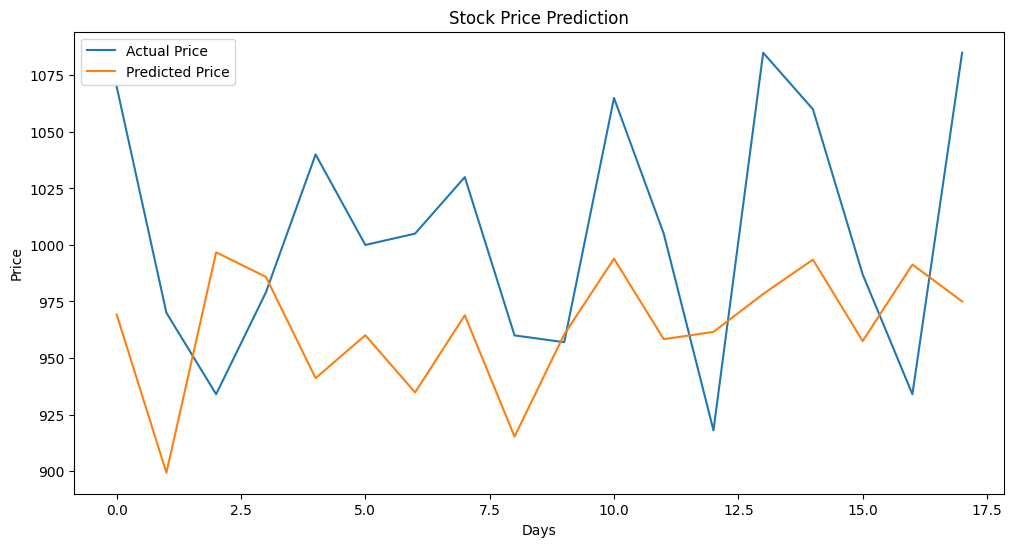

In [15]:
def prepare_data(stock_data, look_back, forecast_horizon):
    data = stock_data['Close'].values
    scaler = MinMaxScaler(feature_range=(0, 1))
    data = scaler.fit_transform(data.reshape(-1, 1))

    X, y = [], []
    for i in range(len(data) - look_back - forecast_horizon + 1):
        X.append(data[i:i + look_back])
        y.append(data[i + look_back + forecast_horizon - 1])

    X, y = np.array(X), np.array(y)
    return X, y, scaler

# 2. 設定參數
look_back = 30  # 使用前30天的數據預測
forecast_horizon = 5  # 預測5天後的股價

X, y, scaler = prepare_data(stock_data, look_back, forecast_horizon)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 轉換為Tensor
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

# 3. 定義模型
class StockPricePredictor(nn.Module):
    def __init__(self, input_dim):
        super(StockPricePredictor, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)  # 首層入口64個線性內部點
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(64, 32)  # 下一層為32點
        self.fc3 = nn.Linear(32, 1)  # 最後進入預測的單個數值

    def forward(self, x):
        x = x.view(x.size(0), -1)  # 平體數據
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        return x

model = StockPricePredictor(input_dim=look_back)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 4. 訓練模型
epochs = 100
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train)
    loss = criterion(outputs.squeeze(), y_train)
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch + 1}/{epochs}], Loss: {loss.item():.4f}")

# 5. 測試模型
model.eval()
with torch.no_grad():
    predictions = model(X_test).squeeze()
    test_loss = criterion(predictions, y_test)
    print(f"Test Loss: {test_loss.item():.4f}")

# 6. 反比例對數據進行返國
predicted_prices = scaler.inverse_transform(predictions.numpy().reshape(-1, 1))
actual_prices = scaler.inverse_transform(y_test.numpy().reshape(-1, 1))

# 7. 顯示預測和實際價格
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(actual_prices, label="Actual Price")
plt.plot(predicted_prices, label="Predicted Price")
plt.xlabel("Days")
plt.ylabel("Price")
plt.title("Stock Price Prediction")
plt.legend()
plt.show()
